# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

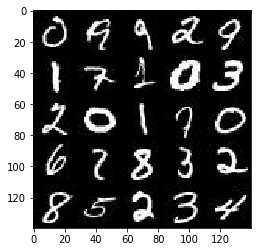

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

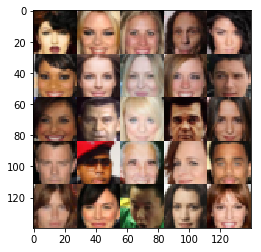

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32, None)

    return input_images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse = reuse):        
        #28x28ximage_depth
        conv1 = tf.layers.conv2d(images, 128, [5, 5], strides = [2, 2], padding = "same")
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        #14x14x128
        conv2 = tf.layers.conv2d(conv1, 256, [5, 5], strides = [1, 1], padding = "same", use_bias = False)
        conv2 = tf.layers.batch_normalization(conv2, training = True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        #14x14x256
        conv3 = tf.layers.conv2d(conv1, 512, [5, 5], strides = [2, 2], padding = "same", use_bias = False)
        conv3 = tf.layers.batch_normalization(conv2, training = True)
        conv3 = tf.maximum(alpha * conv2, conv2)
        
        #7x7x515
        conv4 = tf.layers.conv2d(conv3, 1024, [5, 5], strides = [1, 1], padding = "same", use_bias = False)
        conv4 = tf.layers.batch_normalization(conv4, training = True)
        conv4 = tf.maximum(alpha * conv4, conv4)
        
        #flatten: (4x4ximage_depth)
        flatten = tf.reshape(conv3, [-1, 7*7*1024])
        flatten = tf.nn.dropout(flatten, 0.8)
        logits = tf.layers.dense(flatten, 1, activation = None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse = not is_train):
        x = tf.layers.dense(z, 7 * 7 * 1024, activation = None, use_bias = False)
        x = tf.reshape(x, [-1, 7, 7, 1024])
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.8)
        
        #input x: 7x7x1024
        conv1 = tf.layers.conv2d_transpose(x, 512, [5, 5], strides = [1, 1], padding = "same", use_bias = False)
        conv1 = tf.layers.batch_normalization(conv1, training = is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        #input conv1: 7x7x512
        conv2 = tf.layers.conv2d_transpose(conv1, 256, [5, 5], strides = [2, 2], padding = "same", use_bias = False)
        conv2 = tf.layers.batch_normalization(conv2, training = is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        #input conv2: 14x14x256
        conv3 = tf.layers.conv2d_transpose(conv2, 128, [5, 5], strides = [1, 1], padding = "same", use_bias = False)
        conv3 = tf.layers.batch_normalization(conv3, training = is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        #input conv3: 14x14x128
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, [5, 5], strides = [2, 2], padding = "same")
        out = tf.tanh(logits)
        #output: 32x32xOut_channel_dim
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    sample_z = np.random.uniform(-1, 1, size=(25, z_dim))
    
    image_channels = 3
    if data_image_mode == "L":
        image_channels = 1
    
    input_images, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_images, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #scale images to [-1, 1]
                batch_images = batch_images * 2
                                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                steps += 1

        print("Training End! Showing final results")
        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.6301... Generator Loss: 0.0111


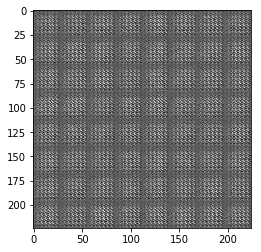

Epoch 1/2... Discriminator Loss: 0.1555... Generator Loss: 2.2549
Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 4.4720
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 4.4606
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 1.1101
Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 1.3931
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.5727
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 2.8304
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.1686


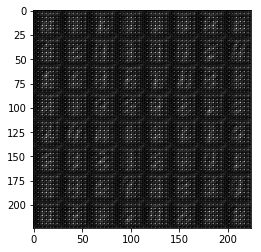

Epoch 1/2... Discriminator Loss: 1.8911... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.8398... Generator Loss: 0.3591
Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 0.3486
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.3628
Epoch 1/2... Discriminator Loss: 1.7478... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 1.1369
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 1.4408
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 1.3615


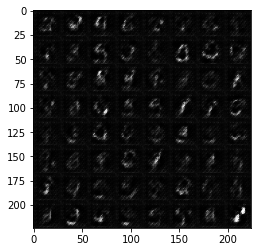

Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 1.6372... Generator Loss: 1.5021
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.6983... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 2.1571
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.5423... Generator Loss: 0.4066
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.4039


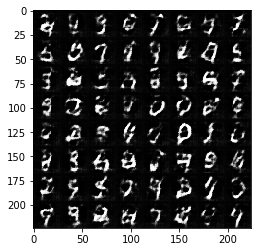

Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.6518... Generator Loss: 0.3569
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 1.1561
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.0269
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 2.0719
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.4479
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.6144


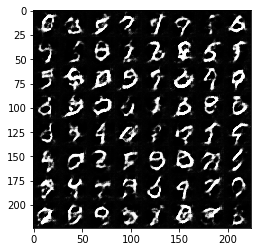

Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 2.0739
Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 2.0743
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.2632
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 0.5628
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.6643
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 1.3882


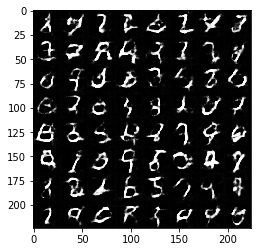

Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 1.3395
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.5075
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 0.3675
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.4480
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.4286
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.7008


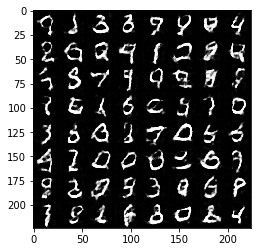

Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.4592
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 1.4199
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 1.3053
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 1.6449


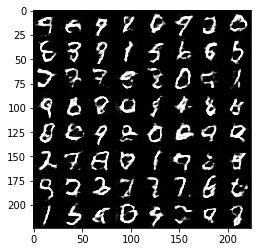

Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 1.1519
Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 0.3522
Epoch 2/2... Discriminator Loss: 2.3850... Generator Loss: 0.1312
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 1.5135
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 0.8019


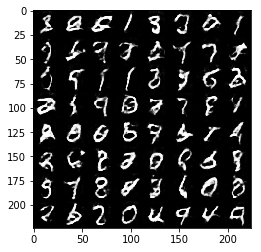

Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 1.4574
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 1.1500
Epoch 2/2... Discriminator Loss: 2.0123... Generator Loss: 1.9495
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 1.4295
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 1.4967... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 1.0231


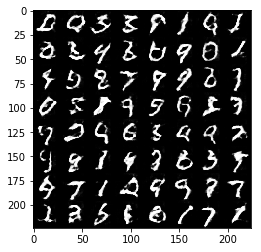

Epoch 2/2... Discriminator Loss: 1.4993... Generator Loss: 0.3748
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.5012
Training End! Showing final results


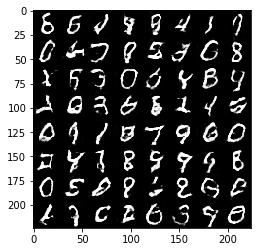

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.8072... Generator Loss: 0.0014


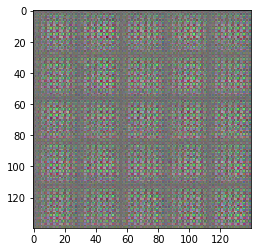

Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 3.0301
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 3.2034
Epoch 1/1... Discriminator Loss: 2.9229... Generator Loss: 0.0833
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 3.7440
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 4.0821
Epoch 1/1... Discriminator Loss: 2.1355... Generator Loss: 0.5350


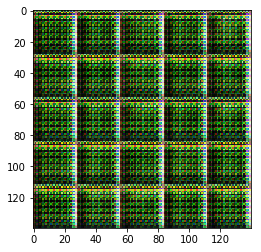

Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.8338... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 2.0653... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 0.4354


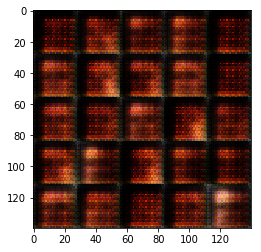

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.9332
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5488


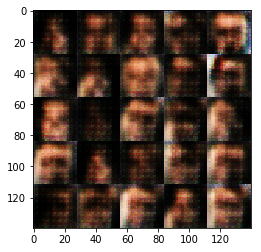

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 2.0358
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 2.0467
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 3.2491
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 2.0583


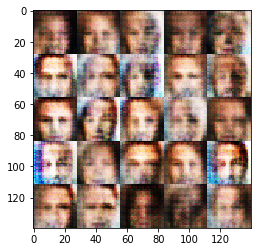

Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.6564
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 2.3483... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 1.9646... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.6925


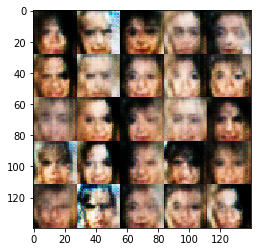

Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.7442
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.6829
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 2.4123... Generator Loss: 2.1877
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.3026
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.9687


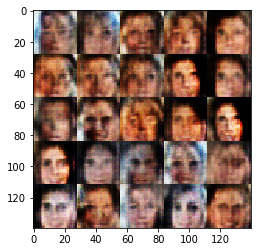

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 2.2308
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.5056


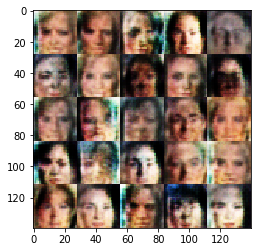

Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.8295


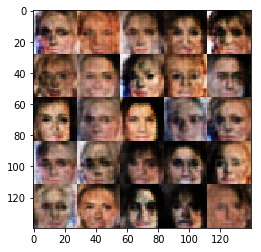

Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 1.8947
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.8282... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 4.4803


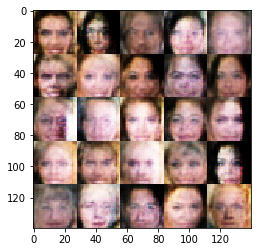

Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.5725
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.2553


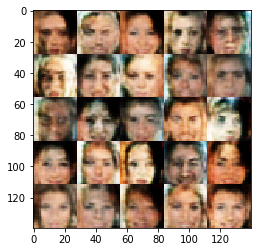

Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.2902


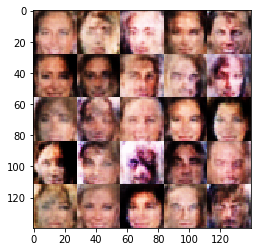

Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.5150
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.8282
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.4888


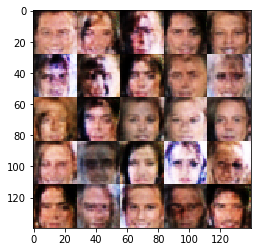

Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.7211
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.6807


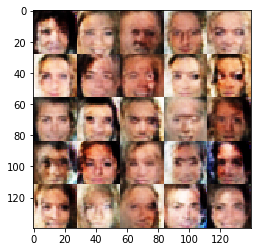

Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.8100
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 3.7387
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.4525
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6003


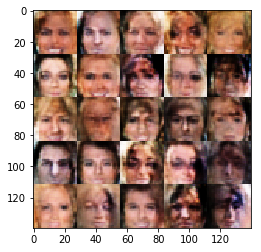

Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.0804


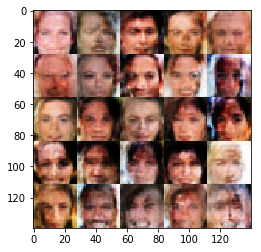

Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.0255
Training End! Showing final results


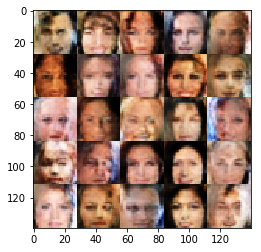

In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.